### NOTICE:
1. remember that this is only a sample copied form kaggle kernal, [the original scripit is here](https://www.kaggle.com/guyko81/allstate-claims-severity/just-an-easy-solution/comments)
2. having problem with install xgboost packages? [link](https://github.com/dmlc/xgboost/tree/master/python-package)


In [1]:
import xgboost as xgb
from scipy.stats import norm, lognorm, probplot
import matplotlib.mlab as mlab
%matplotlib inline

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

features = [x for x in train.columns if x not in ['id','loss']]
cat_features = [x for x in train.select_dtypes(include=['object']).columns if x not in ['id','loss']]
num_features = [x for x in train.select_dtypes(exclude=['object']).columns if x not in ['id','loss']]

print('train size is {}, test size is {}'.format(train.shape,test.shape) )

train size is (188318, 132), test size is (125546, 131)


if the loss follows a log-normal distribution

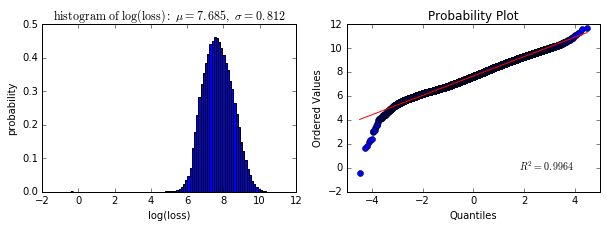

In [3]:
train['log_loss'] = np.log(train['loss']) # https://www.zhihu.com/question/22012482
f,(fig1,fig2) = plt.subplots(1,2,figsize = (10,3))
fig1.hist(np.log(train['loss']),bins=100,normed = 1)
fig1.set_xlabel('log(loss)')
fig1.set_ylabel('probability')
(mu , sigma) = norm.fit(train['log_loss'])
fig1.set_title(r'$\mathrm{histogram\ of\ log(loss):}\ \mu=%.3f,\ \sigma=%.3f$' %(mu, sigma))

probplot(np.log(train['loss']),plot=fig2)

plt.show()

- now, to prepare for xgboost, we turn category data from both train&test  into numeric 0,1,2,3...

In [4]:
nrow_train = train.shape[0]

train_test = pd.concat((train[features],test[features]),axis=0).reset_index(drop=1)

for i in range(len(cat_features)):
    train_test[cat_features[i]] = train_test[cat_features[i]].astype('category').cat.codes

train_x = train_test.iloc[:nrow_train,:]
test_x = train_test.iloc[nrow_train:,:]

- build up the xgboost model

In [5]:
xgbmat = xgb.DMatrix(train_x,train['log_loss'])

params = {'eta': 0.01, 'seed':0, 'subsample': 0.5, 'colsample_bytree': 0.5, 
             'objective': 'reg:linear', 'max_depth':6, 'min_child_weight':3}

num_rounds = 1000

bst = xgb.train(params,xgbmat,num_rounds)
pred = bst.predict(xgb.DMatrix(test_x))

In [6]:
loss = pd.DataFrame(np.e**pred)
id = test['id']
rslt = pd.DataFrame({'id':test['id'],'loss':np.e**pred})

In [7]:
rslt.to_csv('result1.csv')